## Скачиваем пакеты

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statistics as stat

In [2]:
#pip install xgboost

## План по функциям


1. Скачиваем X_train, y_train, X_test, удаляем indexes из X_test. Ф-ция  upload()
2. Объединяем X_train и X_test -> Не буду делать. 
3. Выкидываем выбросы из X_train и y_train. Ф-ция manual_drop()
4. Scale X_train и X_test, учимся на X_train. Ф-ция scale()


## Создаём функция \$\textit{upload()}\$

In [2]:
def upload():
    global X_train
    global y_train
    global X_test
    global scaler
    global indexes
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv')
    X_test = pd.read_csv('X_test.csv')
    indexes = X_test[['index']]
    X_test.drop('index', axis = 1, inplace = True)
    

## Создаём функция \$\textit{fill_na_median()}\$

In [14]:
def fill_na_median():
    global X_train
    global X_test
    X_train['monthly_income'] = X_train['monthly_income'].fillna(X_train['monthly_income'].median())
    X_train['family_members'] = X_train['family_members'].fillna(X_train['family_members'].median())
    X_test['monthly_income'] = X_test['monthly_income'].fillna(X_test['monthly_income'].median())
    X_test['family_members'] = X_test['family_members'].fillna(X_test['family_members'].median())

In [4]:
upload()

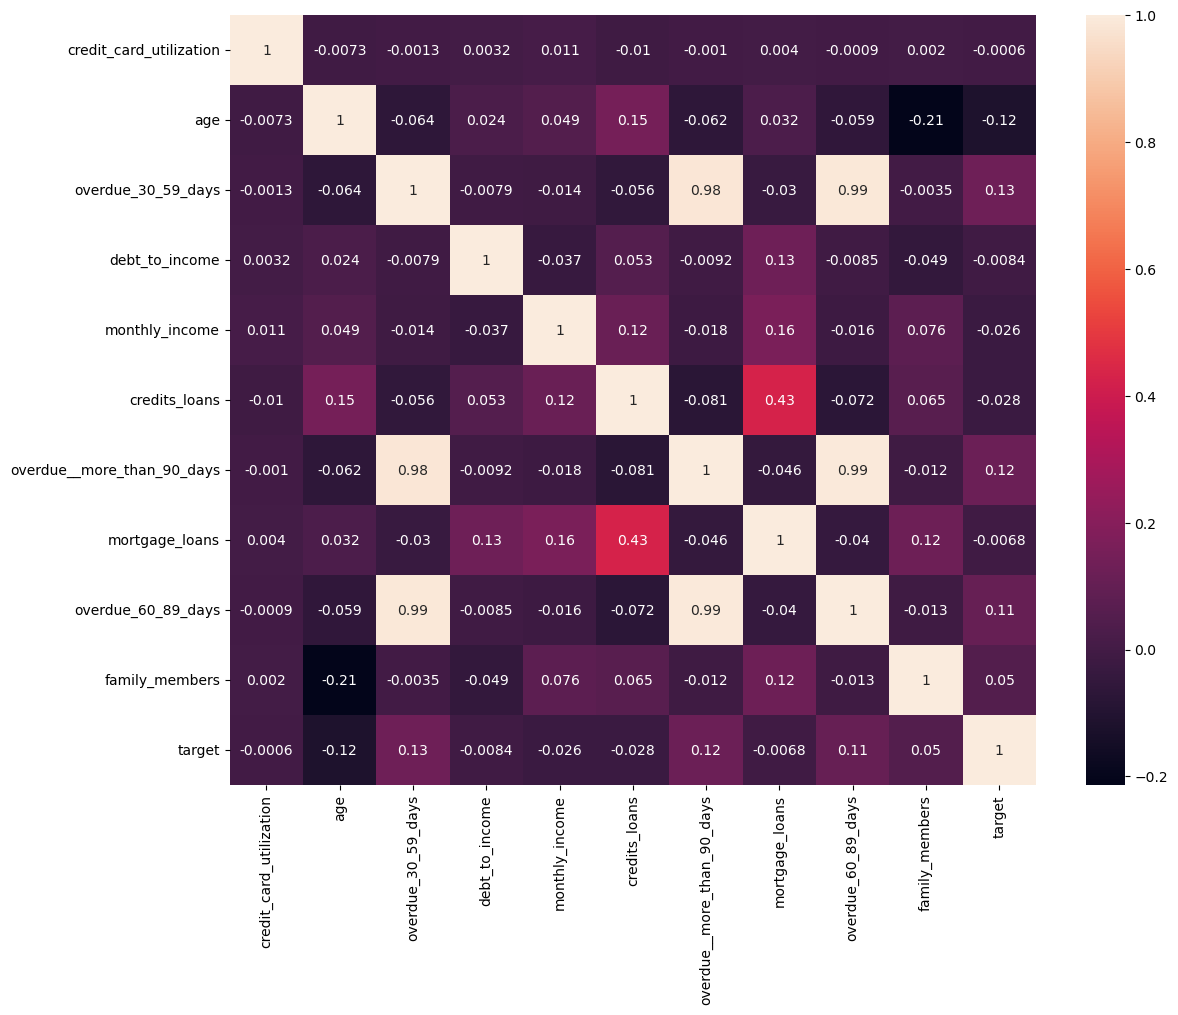

In [5]:
X_train['target'] = y_train
plt.figure(figsize = (13, 10), dpi = 100)
sns.heatmap(data =  X_train.corr().round(4), annot = True)
plt.show()

Из корреляционной матрицы видно, что credit_card_utilization черезвычайно слабо связана с target, поэтому можно поробовать выкинуть этот параметр и посмотреть, каков будет roc_auc без него. 

Помимио этот видно, что 'overdue_30_59_days' сильно связано с 'overdue_60_89_days' и 'overdue_more_than_90_days'. Я попробовал выкинуть признаки 'overdue_60_89_days' и 'overdue_more_than_90_days'. Однако это привело к очень сильному падению roc_auc:      c ~ 0.86 до 0.8296.

Также была идея выкинуть признак credit_card_utilization. Реализовал это только для XGboost. Улучшение было на уровне погрешности. Может, на пару 1/10'000 смог выиграть.

## Пару графиков X_train после чистки

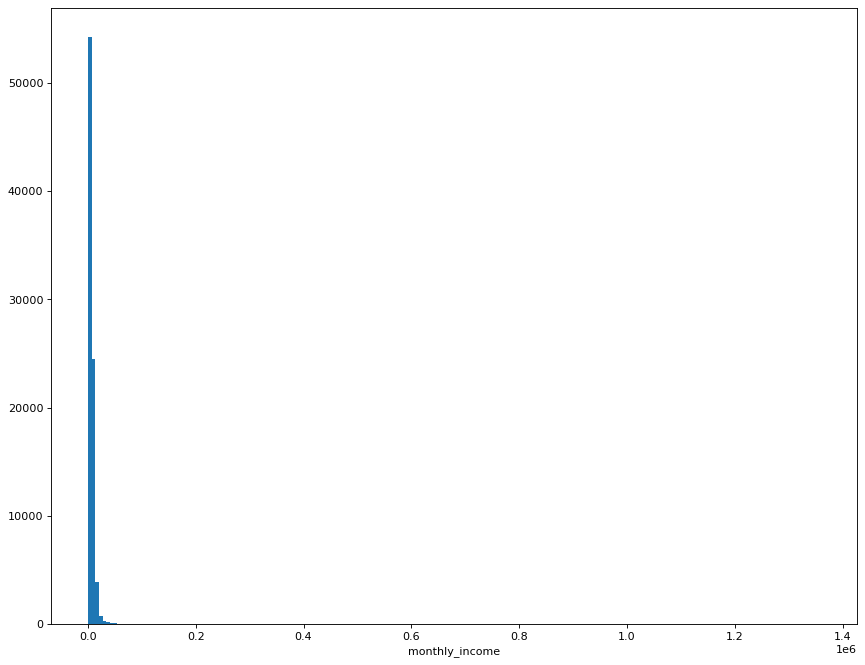

In [6]:
plt.figure(figsize = (13, 10), dpi = 80)
plt.hist(X_train['monthly_income'], bins = 200)
plt.xlabel('monthly_income')
plt.show()

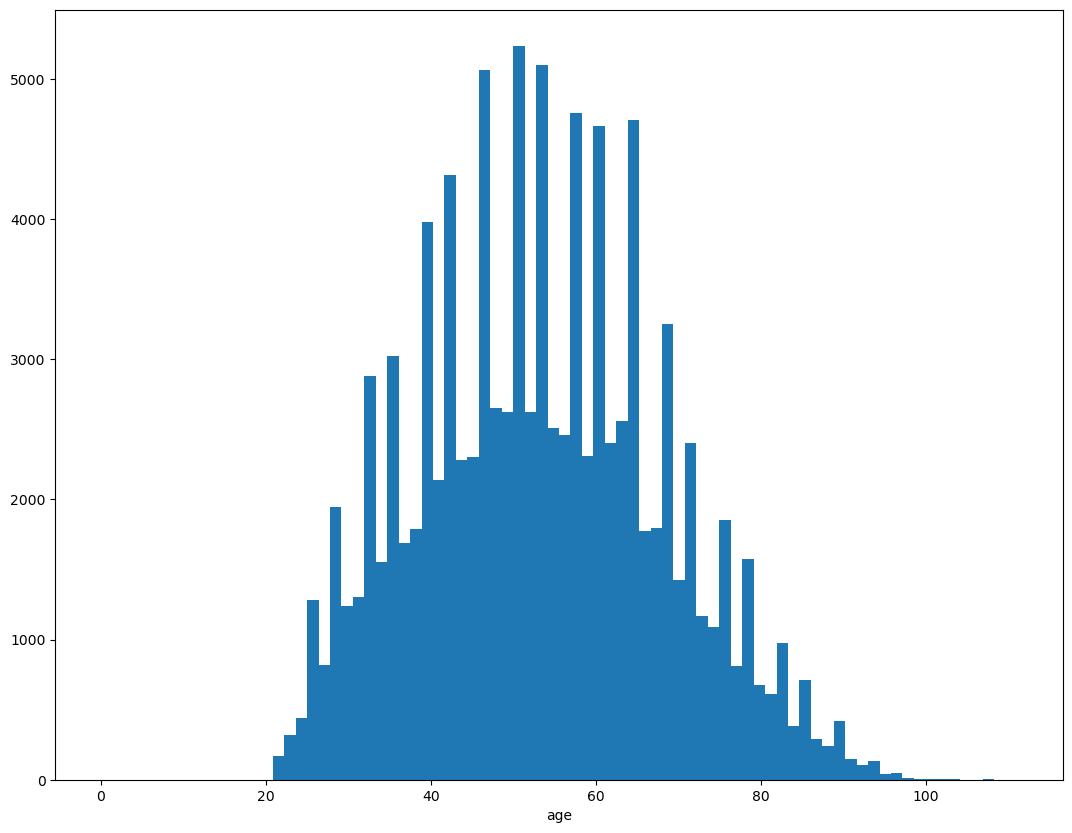

In [7]:
plt.figure(figsize = (13, 10), dpi = 100)
plt.hist(X_train['age'], bins = 80)
plt.xlabel('age')
plt.show()

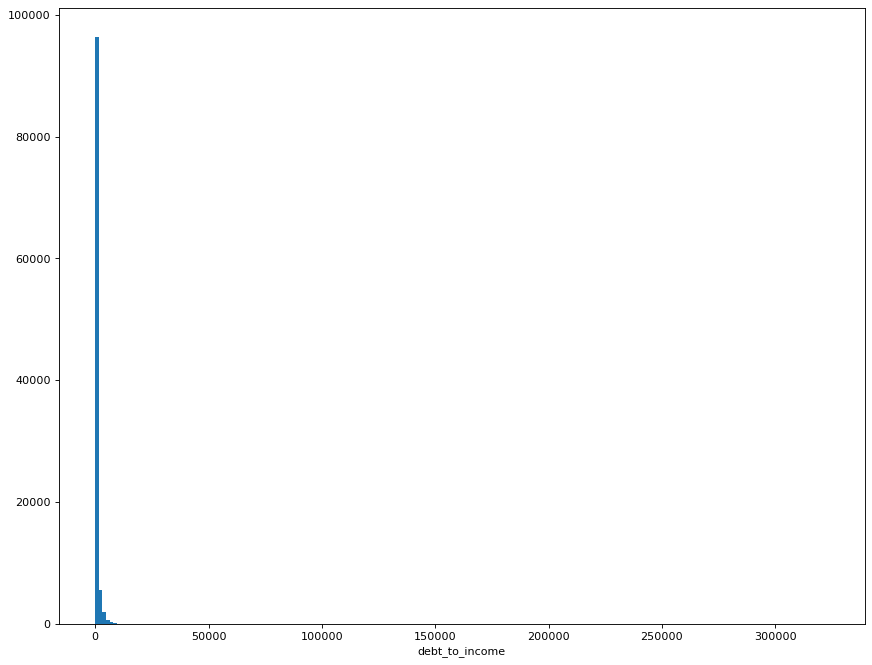

In [8]:
plt.figure(figsize = (13, 10), dpi = 80)
plt.hist(X_train['debt_to_income'], bins = 200)
plt.xlabel('debt_to_income')
plt.show()


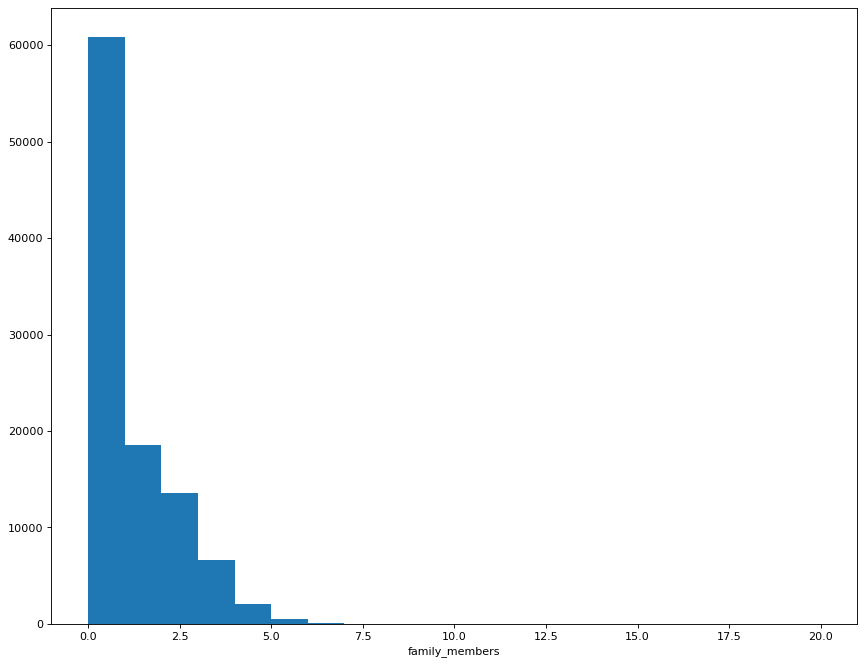

In [9]:
plt.figure(figsize = (13, 10), dpi = 80)
plt.hist(X_train['family_members'], bins = 20)
plt.xlabel('family_members')
plt.show()

## X_test и X_train сравниваются

In [10]:
quantile_drop()

NameError: name 'quantile_drop' is not defined

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "credit_card_utilization", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "credit_card_utilization", ax=ax2)

<AxesSubplot:xlabel='age', ylabel='overdue_30_59_days'>

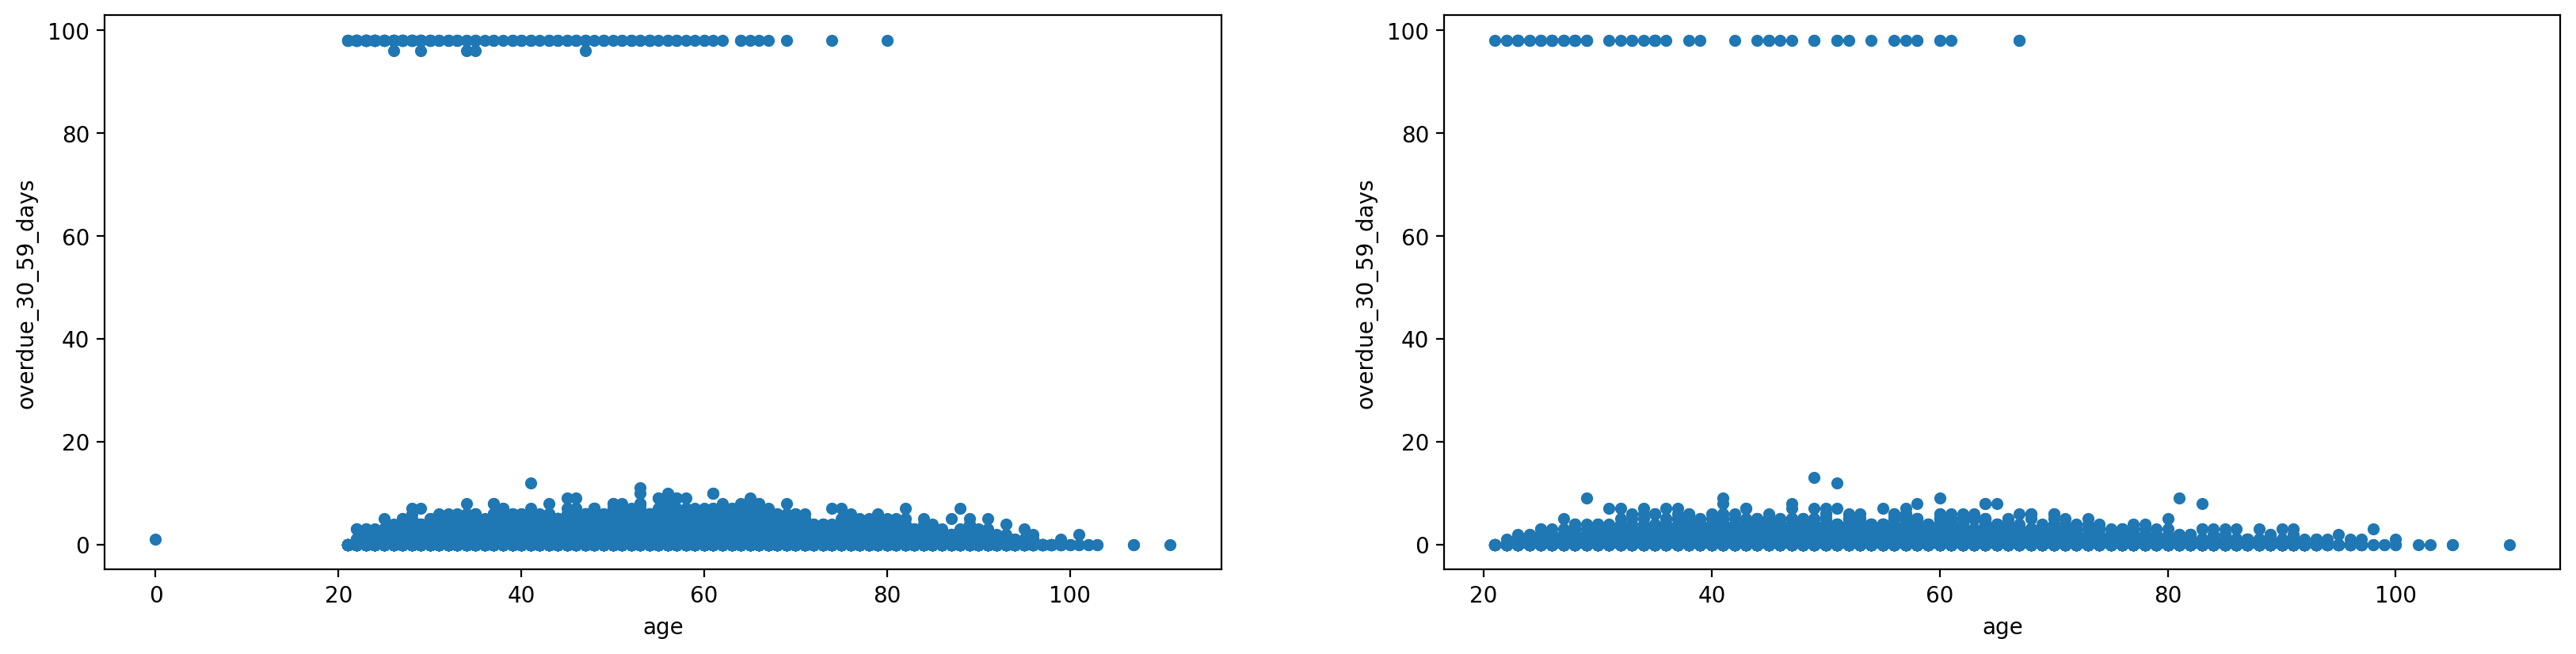

In [11]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "overdue_30_59_days", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "overdue_30_59_days", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "debt_to_income", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "debt_to_income", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "monthly_income", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "monthly_income", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "credits_loans", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "credits_loans", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "overdue__more_than_90_days", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "overdue__more_than_90_days", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "mortgage_loans", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "mortgage_loans", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "overdue_60_89_days", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "overdue_60_89_days", ax=ax2)

In [ ]:
fig = plt.figure(2, figsize = (20,10), dpi = 200)
ax1 = fig.add_subplot(2, 2, 1)
X_train.plot.scatter(x = "age", y = "family_members", ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
X_test.plot.scatter(x = "age", y = "family_members", ax=ax2)

## Создаём функция \$\textit{manual\_ drop()}\$

Функция manual_drop() выкидывает наблюдения, которые превышают верхнюю границу или недостают до нижней. Границы задаются вручную.

Я, в итоге, пользовался quantile_drop()

In [12]:
upload()
manual_drop()

NameError: name 'manual_drop' is not defined

In [15]:
def manual_drop():
    global y_train
    global X_train
    y_train = y_train.loc[(X_train['credit_card_utilization'] >= 0)& (X_train['credit_card_utilization'] <=30000)]
    X_train = X_train.loc[(X_train['credit_card_utilization'] >= 0)& (X_train['credit_card_utilization'] <=30000)]
    y_train = y_train.loc[(X_train['age'] >= 20)& (X_train['age'] <=100)]
    X_train = X_train.loc[(X_train['age'] >= 20)& (X_train['age'] <=100)]
    y_train = y_train.loc[(X_train['debt_to_income'] >= 0)& (X_train['debt_to_income'] <=100000)]
    X_train = X_train.loc[(X_train['debt_to_income'] >=0)& (X_train['debt_to_income'] <=100000)]
    y_train = y_train.loc[(X_train['monthly_income'] >= 0)& (X_train['monthly_income'] <=40000)|(X_train['monthly_income'].isnull() == True)]
    X_train = X_train.loc[(X_train['monthly_income'] >= 0)& (X_train['monthly_income'] <=40000)|(X_train['monthly_income'].isnull() == True)]
    y_train = y_train.loc[(X_train['credits_loans'] >= 0)& (X_train['credits_loans'] <=45)]
    X_train = X_train.loc[(X_train['credits_loans'] >= 0)& (X_train['credits_loans'] <=45)]
    y_train = y_train.loc[(X_train['mortgage_loans'] >= 0)& (X_train['mortgage_loans'] <=25)]
    X_train = X_train.loc[(X_train['mortgage_loans'] >= 0)& (X_train['mortgage_loans'] <=25)]
    y_train = y_train.loc[(X_train['family_members'] >= 0)& (X_train['family_members'] <=11)|(X_train['family_members'].isnull() == True)]
    X_train = X_train.loc[(X_train['family_members'] >= 0)& (X_train['family_members'] <=11)|(X_train['family_members'].isnull() == True)]

## Создаём функция \$\textit{scale()}\$

Функция scale() стандартизует данные. Подбираем \$\mathcal{M}\$ и \$\mathcal{D}\$ на X_train

In [16]:
def scale(X_tr, X_t): #X_tr - X_train, X_t - X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_tr)
    X_test = scaler.transform(X_t)
    
    return X_train, X_test

## Убираем выбросы квантилями

In [17]:
def quantile_drop():
    global X_train
    global y_train
    col1_max = float(X_train[['credit_card_utilization']].quantile(0.997))
    col1_min = float(X_train[['credit_card_utilization']].quantile(0.003))
    col2_max = float(X_train[['age']].quantile(0.997))
    col2_min = float(X_train[['age']].quantile(0.003))
    col3_max = float(X_train[['overdue_30_59_days']].quantile(0.997))
    col3_min = float(X_train[['overdue_30_59_days']].quantile(0.003))
    col4_max = float(X_train[['debt_to_income']].quantile(0.997))
    col4_min = float(X_train[['debt_to_income']].quantile(0.003))
    col5_max = float(X_train[['monthly_income']].quantile(0.997))
    col5_min = float(X_train[['monthly_income']].quantile(0.003))
    col6_max = float(X_train[['credits_loans']].quantile(0.997))
    col6_min = float(X_train[['credits_loans']].quantile(0.003))
    col7_max = float(X_train[['overdue__more_than_90_days']].quantile(0.997))
    col7_min = float(X_train[['overdue__more_than_90_days']].quantile(0.003))
    col8_max = float(X_train[['mortgage_loans']].quantile(0.997))
    col8_min = float(X_train[['mortgage_loans']].quantile(0.003))
    col9_max = float(X_train[['overdue_60_89_days']].quantile(0.997))
    col9_min = float(X_train[['overdue_60_89_days']].quantile(0.003))
    col10_max = float(X_train[['family_members']].quantile(0.997))
    col10_min = float(X_train[['family_members']].quantile(0.003))
    y_train = y_train.loc[((X_train['credit_card_utilization'] <= col1_max)&(X_train['credit_card_utilization']>=col1_min))&((X_train['age'] <= col2_max)&(X_train['age'] >= col2_min))&((X_train['overdue_30_59_days']<= col3_max)&(X_train['overdue_30_59_days']>= col3_min))&((X_train['debt_to_income']<=col4_max)&(X_train['debt_to_income']>=col4_min))&(((X_train['monthly_income']<=col5_max)&(X_train['monthly_income']>=col5_min))|(X_train['monthly_income'].isnull()==True)) & ((X_train['credits_loans'] <= col6_max)&(X_train['credits_loans'] >= col6_min))& ((X_train['overdue__more_than_90_days'] <= col7_max)&(X_train['overdue__more_than_90_days'] >= col7_min))&((X_train['mortgage_loans'] <= col8_max)&(X_train['mortgage_loans'] >= col8_min))&((X_train['overdue_60_89_days'] <= col9_max)&(X_train['overdue_60_89_days'] >= col9_min))& (((X_train['family_members'] <= col10_max)&(X_train['family_members'] >= col10_min))|(X_train['family_members'].isnull()==True))]
    X_train = X_train.loc[((X_train['credit_card_utilization'] <= col1_max)&(X_train['credit_card_utilization']>=col1_min))&((X_train['age'] <= col2_max)&(X_train['age'] >= col2_min))&((X_train['overdue_30_59_days']<= col3_max)&(X_train['overdue_30_59_days']>= col3_min))&((X_train['debt_to_income']<=col4_max)&(X_train['debt_to_income']>=col4_min))&(((X_train['monthly_income']<=col5_max)&(X_train['monthly_income']>=col5_min))|(X_train['monthly_income'].isnull()==True)) & ((X_train['credits_loans'] <= col6_max)&(X_train['credits_loans'] >= col6_min))& ((X_train['overdue__more_than_90_days'] <= col7_max)&(X_train['overdue__more_than_90_days'] >= col7_min))&((X_train['mortgage_loans'] <= col8_max)&(X_train['mortgage_loans'] >= col8_min))&((X_train['overdue_60_89_days'] <= col9_max)&(X_train['overdue_60_89_days'] >= col9_min))& (((X_train['family_members'] <= col10_max)&(X_train['family_members'] >= col10_min))|(X_train['family_members'].isnull()==True))]

    X_train.reset_index(drop = True, inplace = True)
    y_train.reset_index(drop = True, inplace = True)

### Логистическая регрессия

In [28]:
reg_lr = linear_model.LogisticRegression(max_iter = 84000)

In [29]:
upload()
quantile_drop()

NameError: name 'quantile_drop' is not defined

Если заполнять Na, то будут сильные выбросы, так как у нас 20k наблюдений имеют NA. Мне показалось, что лучше просто эти наблюдения выкинуть. 

In [129]:
smally_train = y_train.loc[ (X_train['monthly_income'].isnull()== False) & (X_train['family_members'].isnull() == False) ]
smallX_train = X_train.loc[ (X_train['monthly_income'].isnull()== False) & (X_train['family_members'].isnull() == False) ]

In [130]:
smallX_train_s, X_test_s = scale(smallX_train, X_test)

In [131]:
print(smallX_train.shape)
print(smally_train.shape)

(82576, 10)
(82576, 1)


In [133]:
param_grid_lr = {
    "penalty": ['elasticnet'],
    "C": [0.001, 0.01, 0.1, 0.25, 0.5],
    "l1_ratio":[0, 0.25, 0.5, 0.9, 1], 
    "solver":['saga']
}

Выбрал именно эти параметры, так как они борятся с переобучением модели. Взял elasticnet, так как это комбинация l1 и l2 penalties. Если l1_ratio=0, это l2, если l1_ratio=1, это l1.
Другие мне показались бессмысленными(как, н-р, способ поиска экстремума, модель, наверное, должна сама их подбирать).

Выбрал saga, так как это единственный solver, который поддерживает elasticnet

In [134]:
grid_cv_lr1 = GridSearchCV(reg_lr, param_grid_lr, n_jobs=-1, cv=3, scoring = 'roc_auc')

In [135]:
_ = grid_cv_lr1.fit(smallX_train_s, smally_train)

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [27]:
grid_cv_lr1.best_score_

0.7060911134083163

In [28]:
grid_cv_lr1.best_params_

{'C': 0.001, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'}

ROC_AUC = 0.71 на Kaggle

### Не хочу делать train-test split, чтобы не ухудшать результат использования данных.
### То есть, метрики будут завышены. 

In [30]:
print(classification_report(y_true = smally_train, y_pred = grid_cv_lr1.predict(smallX_train_s)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     78201
           1       0.60      0.01      0.02      5864

    accuracy                           0.93     84065
   macro avg       0.77      0.51      0.49     84065
weighted avg       0.91      0.93      0.90     84065



### Так как \$ \textit{l1_ratio = 1}\$, то попробуем сделать для \$ \textit{penalty = l1}\$

In [294]:
param_grid_lr = {
    "penalty": ['l1'],
    "C": [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.95], 
    "solver": ['liblinear', "saga"]
}

In [295]:
grid_cv_lr2 = GridSearchCV(reg_lr, param_grid_lr, n_jobs=-1, cv=3, scoring = 'roc_auc')

In [296]:
_ = grid_cv_lr2.fit(smallX_train_s, smally_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [297]:
grid_cv_lr2.best_score_

0.7124569443901037

ROC_AUC = 0.71 на Kaggle

In [298]:
grid_cv_lr2.best_params_

{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

In [299]:
print(classification_report(y_true = smally_train, y_pred = grid_cv_lr2.predict(smallX_train_s)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     78201
           1       0.60      0.01      0.02      5864

    accuracy                           0.93     84065
   macro avg       0.77      0.51      0.49     84065
weighted avg       0.91      0.93      0.90     84065



### Пробуем l2

In [300]:
param_grid_lr = {
    "penalty": ['l2'],
    "C": [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.95],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [301]:
grid_cv_lr3 = GridSearchCV(reg_lr, param_grid_lr, n_jobs=-1, cv=3, scoring = 'roc_auc')

In [302]:
_ = grid_cv_lr3.fit(smallX_train_s, smally_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [303]:
grid_cv_lr3.best_score_

0.6918626155844674

ROC_AUC = 0.6917 на Kaggle

In [304]:
grid_cv_lr3.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [305]:
print(classification_report(y_true = smally_train, y_pred = grid_cv_lr3.predict(smallX_train_s)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     78201
           1       0.58      0.03      0.06      5864

    accuracy                           0.93     84065
   macro avg       0.75      0.51      0.51     84065
weighted avg       0.91      0.93      0.90     84065



# kNN

In [306]:
reg_kNN = KNeighborsClassifier()

In [307]:
upload()
manual_drop()

In [308]:
smallX_train = X_train.loc[ (X_train['monthly_income'].isnull()== False) & (X_train['family_members'].isnull() == False) ]
smally_train = y_train.loc[ (X_train['monthly_income'].isnull()== False) & (X_train['family_members'].isnull() == False) ]

In [309]:
smallX_train_s, X_test_s = scale(smallX_train, X_test)

In [310]:
print(smallX_train.shape)
print(smally_train.shape)

(84065, 10)
(84065, 1)


In [311]:
param_grid_kNN = {
    "weights":['uniform', 'distance'], # 
    "p":[1, 2, 5],# Различные виды метрики Минковского
    "n_neighbors": [2,5, 10, 20, 40, 80, 120, ]# Просто расзное число соседей
}

In [312]:
grid_cv_kNN = GridSearchCV(reg_kNN, param_grid_kNN, n_jobs=-1, cv=3, scoring="roc_auc")

In [313]:
_ = grid_cv_kNN.fit(smallX_train_s, smally_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [317]:
grid_cv_kNN.best_score_

0.7639422644352759

ROC_AUC на Kaggle = 0.7642

In [318]:
grid_cv_kNN.best_params_

{'n_neighbors': 120, 'p': 1, 'weights': 'uniform'}

In [323]:
print(classification_report(y_true = smally_train, y_pred = grid_cv_kNN.predict(smallX_train_s)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     78201
           1       0.62      0.01      0.03      5864

    accuracy                           0.93     84065
   macro avg       0.77      0.51      0.50     84065
weighted avg       0.91      0.93      0.90     84065



## Random Forest

На Kaggle выбил ROC_AUC= 0.8602

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier()

In [34]:
param_grid_rf  = {
    "max_depth":[5, 6, 7, 8, 9, 10],
    "min_samples_split":[2, 3, 4],
    "max_features":['sqrt']#sqrt подходит наилучшем образом для задачи классификации
}

In [35]:
grid_cv_rf = RandomizedSearchCV(forest, param_grid_rf, n_jobs=-1, cv=3, scoring="roc_auc")

In [36]:
fill_na_median()# Здесь решил заполнить NA 

In [38]:
_ = grid_cv_rf.fit(X_train,y_train)

C:\Users\Serge\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [80]:
forest=RandomForestClassifier()
forest.fit(X_train,y_train)
y_predicted_proba = pd.DataFrame(forest.predict_proba(X_test)[:, 1])
result = pd.concat([indexes, y_predicted_proba], axis=1)
result = result.rename(columns={0: "target"})
prediction = result.to_csv('prediction.csv', index = False)

<ipython-input-80-2fd081232ebf>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train,y_train)


In [36]:
grid_cv_rf.best_score_

0.8622966250792414

In [37]:
grid_cv_rf.best_params_

{'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}

ROC_AUC на Kaggle = 0.8602

min_sapmle: split довольно маленький, так как RF использует довольно глубокие деревья 
max_depth: тут аналогично предыдущим рассуждения. 

### График ROC_AUC score от числа fold'ов

In [32]:
score1 = []
k_list1 = []
for k in range(2, 8):
    param_grid_rf = {
    "max_depth": [10],
    'max_features': ['sqrt'],
    'min_samples_split': [4]}
    grid_cv_rf = GridSearchCV(forest, param_grid_rf, n_jobs=-1, cv=k, scoring="roc_auc")
    _ = grid_cv_rf.fit(X_train,y_train)
    score1.append(grid_cv_rf.best_score_)
    k_list1.append(k)

NameError: name 'forest' is not defined

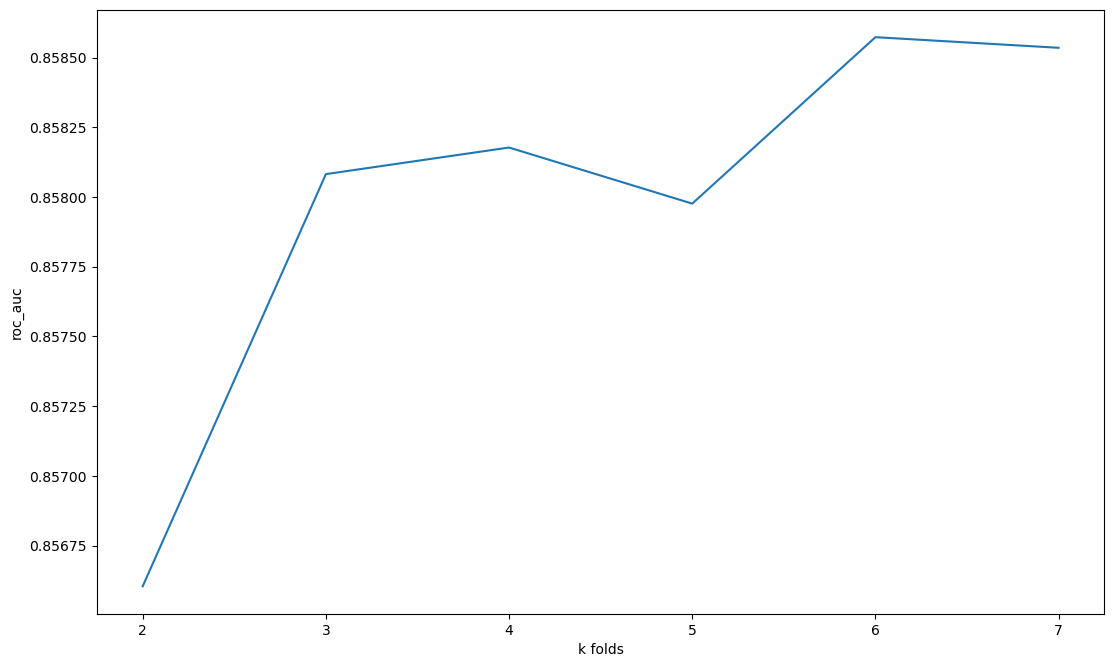

In [16]:
plt.figure(figsize = (13, 8), dpi = 100, edgecolor='#008080')
plt.xlabel('k folds')
plt.ylabel('roc_auc')
plt.plot(k_list1, score1 )
plt.show()

Результат на CV сильно отличается от результата на реальных данных, поэтому оптимальнее всего брать 3 fold'а, так как рост от 2 до 3 заметен, а дельше уже рост не столь большой.


## XGboost

In [18]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

Изначальная param_grid:

In [15]:
param_grid_xg_initial = {
    "max_depth": [3, 4, 5, 6, 7],
    "gamma":[0, 0.01, 0.1, 0.25, 0.5, 0.8],
    "learning_rate": [0.01, 0.1, 0.25, 0.05, 0.06, 0.08, 0.1, 0.25],
    "reg_lambda": [0, 0.01, 0.1, 0.25, 0.6, 0.8, 1, 2, 4, 6, 10],
    "reg_alpha" : [0, 0.01, 0.1, 0.25, 0.6, 0.8, 1, 2, 4, 6, 10],
    "scale_pos_weight": [2],
    "subsample": [0.2,0.4, 0.6, 0.8, 0.95],
    "colsample_bytree": [0.5],
    "n_estimators":[60, 100, 120],
    "min_child_weight":[0.01, 0.1, 0.3, 0.35, 0.4, 0.6, 0.8],
    "max_leaves": [4, 6, 10, 15, 20, 35]
}

In [19]:
param_grid_xg = {
    "max_depth": [6],
    "gamma":[0.7, 0.8, 0.9],
    "learning_rate": [0.05, 0.06, 0.07],
    "reg_lambda": [0.8],
    "reg_alpha" : [8],
    "scale_pos_weight": [2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.5],
    "n_estimators":[100],
    "min_child_weight":[0.35],
    "max_leaves": [10]
}

Выкидывал по квантилям, и выкинул колонку с credit_card_utilization, так как очень низкая корреляция

In [20]:
upload()
quantile_drop()
X_train.drop(columns=  ['credit_card_utilization'])
X_test.drop(columns=['credit_card_utilization'])

,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,60,0,0.184907,14403.715440,9,0,1,0,0.0
1,82,0,0.446264,6768.581963,6,0,3,0,0.0
2,43,1,0.406317,4686.080429,14,0,2,0,3.0
3,31,0,0.311893,3867.175176,8,0,0,0,1.0
4,45,0,0.294956,9869.273012,6,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...
38871,39,0,0.251005,3474.894386,5,0,0,0,0.0
38872,70,0,0.152539,4170.426464,14,0,1,0,0.0
38873,52,0,5288.053772,NaN,15,0,2,0,0.0
38874,51,0,0.378356,5441.458787,9,0,2,0,0.0


In [21]:
grid_cv_xg = GridSearchCV(xgb_cl, param_grid_xg, n_jobs=-1, cv=2, scoring="roc_auc")

In [22]:
X_train_s, X_test_s = scale(X_train, X_test)

In [25]:
_ = grid_cv_xg.fit(X_train_s,y_train)

In [61]:
grid_cv_xg.best_score_

0.8590110095025816

In [213]:
grid_cv_xg.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.8,
 'learning_rate': 0.06,
 'max_depth': 6,
 'max_leaves': 10,
 'min_child_weight': 0.35,
 'n_estimators': 100,
 'reg_alpha': 8,
 'reg_lambda': 0.8,
 'scale_pos_weight': 2,
 'subsample': 0.8}

### Основные метрики бинарное классификации

In [89]:
print(classification_report(y_true = y_train, y_pred = grid_cv_xg.predict(X_train_s)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     96600
           1       0.53      0.36      0.43      6958

    accuracy                           0.94    103558
   macro avg       0.74      0.67      0.70    103558
weighted avg       0.93      0.94      0.93    103558



In [92]:
upload()
quantile_drop()
X_train.drop(columns=  ['credit_card_utilization'])
X_test.drop(columns=['credit_card_utilization'])

,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,60,0,0.184907,14403.715440,9,0,1,0,0.0
1,82,0,0.446264,6768.581963,6,0,3,0,0.0
2,43,1,0.406317,4686.080429,14,0,2,0,3.0
3,31,0,0.311893,3867.175176,8,0,0,0,1.0
4,45,0,0.294956,9869.273012,6,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...
38871,39,0,0.251005,3474.894386,5,0,0,0,0.0
38872,70,0,0.152539,4170.426464,14,0,1,0,0.0
38873,52,0,5288.053772,NaN,15,0,2,0,0.0
38874,51,0,0.378356,5441.458787,9,0,2,0,0.0


## ROC кривая для 2-х основных моделей: RF и XGboost

In [96]:
y_pred_XG = pd.DataFrame(grid_cv_xg.predict_proba(X_train_s)[:, 1])
fill_na_median()
y_pred_RF = pd.DataFrame(grid_cv_rf.predict_proba(X_train)[:, 1])

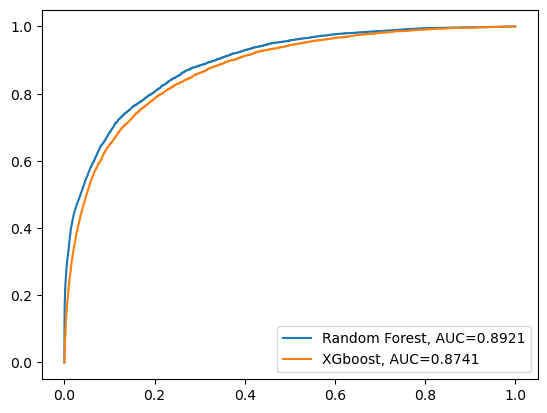

In [98]:
plt.figure(0)
fpr, tpr, _ = roc_curve (y_train, y_pred_RF)
auc = round(roc_auc_score (y_train, y_pred_RF), 4)
plt.plot (fpr,tpr,label="Random Forest, AUC="+str(auc))

fpr, tpr, _ = roc_curve (y_train, y_pred_XG)
auc = round(roc_auc_score (y_train, y_pred_XG), 4)
plt.plot (fpr,tpr,label="XGboost, AUC="+str(auc))

plt.legend() 
plt.show()

### Random_forest, видимо, переобучился, так как на Kaggle XGboost даёт лучше score

In [ ]:
score = []
k_list = []
for k in range(2, 8):
    param_grid_ = {
    "max_depth": [5],
    "gamma":[0.8],
    "learning_rate": [0.05],
    "reg_lambda": [0.8],
    "reg_alpha" : [8],
    "scale_pos_weight": [2],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "n_estimators":[120],
    "min_child_weight":[0.35],
    "max_leaves": [10]}
    grid_cv_xg = GridSearchCV(xgb_cl, param_grid_xg, n_jobs=-1, cv=k, scoring="roc_auc")
    _ = grid_cv_xg.fit(X_train_s,y_train)
    score.append(grid_cv_xg.best_score_)
    k_list.append(k)
    

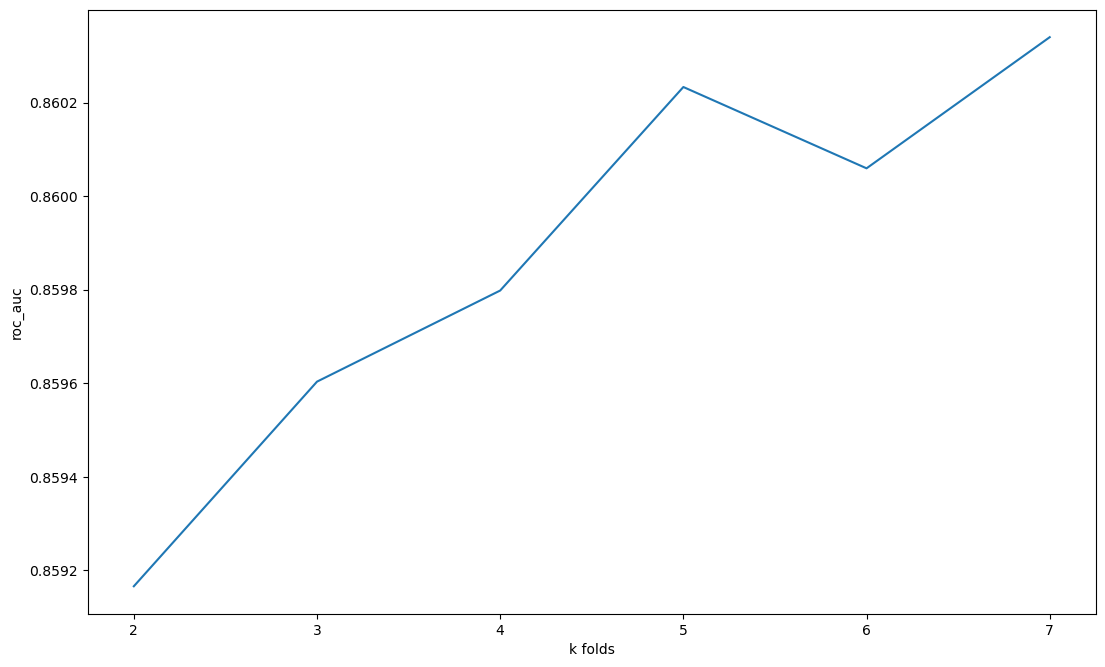

In [185]:
plt.figure(figsize = (13, 8), dpi = 100, edgecolor='#008080')
plt.xlabel('k folds')
plt.ylabel('roc_auc')
plt.plot(k_list, score, )
plt.show()

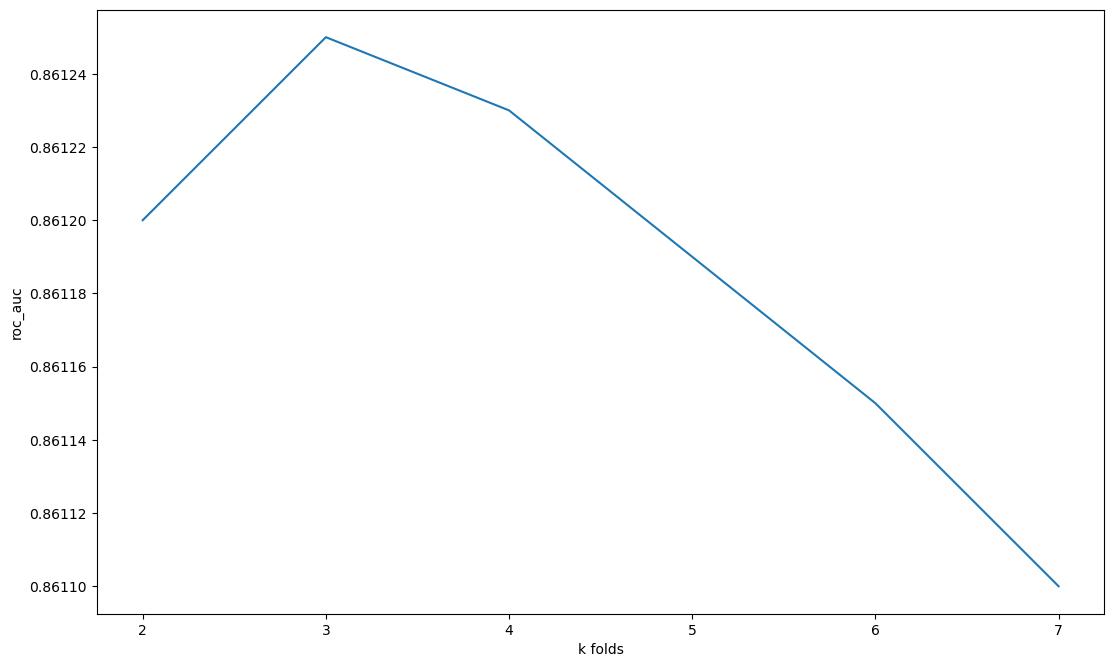

In [222]:
k_folds = list(range(2, 8))
scor = [0.86120, 0.86125, 0.86123, 0.86119 ,  0.86115, 0.86110 ]
plt.figure(figsize = (13, 8), dpi = 100, edgecolor='#008080')
plt.xlabel('k folds')
plt.ylabel('roc_auc')
plt.plot(k_folds, scor, )
plt.show()

In [217]:
y_predicted_proba = pd.DataFrame(grid_cv_xg.predict_proba(X_test_s)[:, 1])

In [218]:
y_predicted_proba

,0
0,0.014424
1,0.026882
2,0.209058
3,0.045145
4,0.020487
...,...
38871,0.120333
38872,0.016723
38873,0.032657
38874,0.105805


In [219]:
result = pd.concat([indexes, y_predicted_proba], axis=1)
result = result.rename(columns={0: "target"})
prediction = result.to_csv('prediction.csv', index = False)

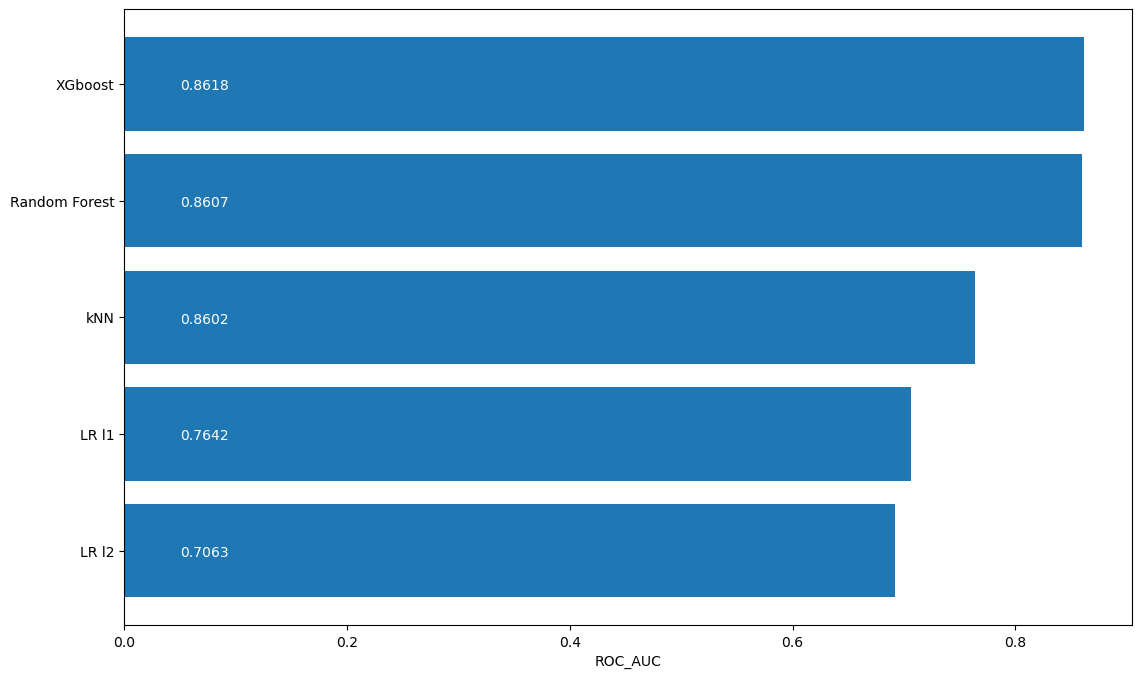

In [47]:
# Это ещё с обшего проекта осталось, пусть будет
plt.rcdefaults()
fig, ax = plt.subplots(dpi = 100, figsize = (13, 8))

# Example data
models = ('XGboost', 'Random Forest', 'kNN', 'LR l1', 'LR l2')
scores = (0.8618, 0.8602, 0.7642, 0.7063, 0.6917)

ax.barh(models,width =scores, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('ROC_AUC')



plt.text(0.05, 0.1-0.05, str(round(0.8618,4)), color='white')
plt.text(0.05, 1.1-0.05, str(round(0.8607,4)), color='white')
plt.text(0.05, 2.1-0.05, str(round(0.8602,4)), color='white')
plt.text(0.05, 3.1-0.05, str(round(0.7642,4)), color='white')
plt.text(0.05, 4.1-0.05, str(round(0.7063,4)), color='white')
plt.text(0.05, 5.1-0.05, str(round(0.6917,4)), color='white')
plt.show()

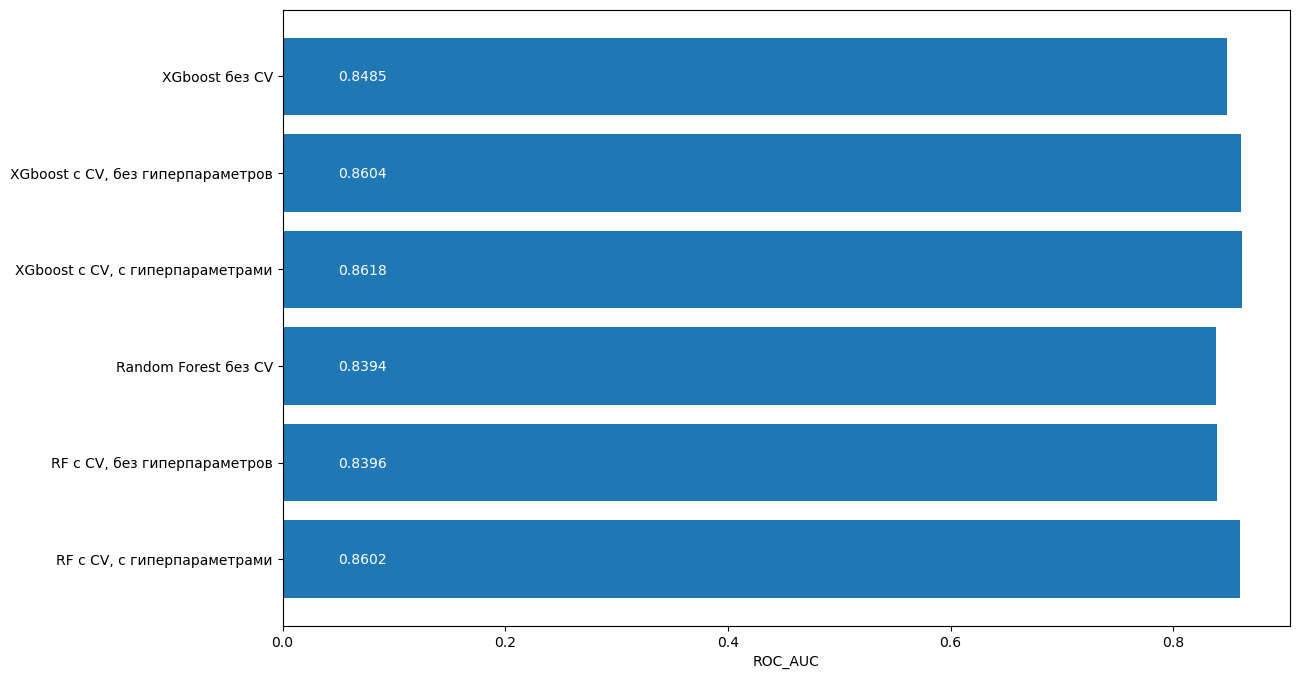

In [113]:
plt.rcdefaults()
fig, ax = plt.subplots(dpi = 100, figsize = (13, 8))

# Example data
models = ('XGboost без CV', 'XGboost c CV, без гиперпараметров', 'XGboost c CV, c гиперпараметрами', 'Random Forest без CV', 'RF c CV, без гиперпараметров', 'RF c CV, c гиперпараметрами')
scores = (0.8485, 0.8604, 0.8618, 0.8385, 0.8396, 0.8602)

ax.barh(y = models, width =scores, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('ROC_AUC')
#('XGboost без CV', 'XGboost c CV\, без гиперпараметров', 'XGboost c CV\, c гиперпараметрами' 'Random Forest без CV', 'Random Forest c CV\, без гиперпараметров', 'Random Forest c CV\, c гиперпараметрами')


plt.text(0.05, 0.1-0.05, str(round(0.8485,4)), color='white')
plt.text(0.05, 1.1-0.05, str(round(0.8604,4)), color='white')
plt.text(0.05, 2.1-0.05, str(round(0.8618,4)), color='white')
plt.text(0.05, 3.1-0.05, str(round(0.8394,4)), color='white')
plt.text(0.05, 4.1-0.05, str(round(0.8396,4)), color='white')
plt.text(0.05, 5.1-0.05, str(round(0.8602,4)), color='white')
plt.show()

# Итог

Лучше всего себя показал XGboost при 3 fold'ах. 
XGboost довольно хорошо себя показал среди всех моделей.